# BTC REGRESSION PREDICTOR

Is it possible to use just raw price data to predict the upcoming price of bitcoin? That is the question I am looking to answer in this notebook. The plan is<br>
to try calculate features from only the date, high, low, open, close and volume for the last 1000 days of price action.

In [295]:
# Import statements

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

In [140]:
# Load our csv as a pandas dataframe
btc = pd.read_csv("BTCUSDT-D.csv")

In [142]:
# Have a squizz at the data
btc.head()

,date,time,open,high,low,close,volume
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382


We have to clean the date column up and split the string apart to only contain the day of the week as my idea is to use that to find a potential pattern <br>
in the price. I think that month in collaboration with day of the week might be handy too but im unsure... So for now we will just try day of the week and <br>
keep months in our back pocket

## Transform the data column, creating features

In [146]:
# Create a list to hold the days of the week
days = []

# Iterate over each date in the data column
for date in btc["date"]:
    # Split the string on the hypphens and take the first string (The abbrivated day)
    day = date.split("-")[0]
    # append the day to the list
    days.append(day)

# Create the new column for our dataframe containing the days of the week
btc["day"] = days
btc.head()

,date,time,open,high,low,close,volume,day
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon


### Calculate features

In [149]:
# Creates a list out of a given column

def create_list(column):
    """
    Takes a pandas column and iterates over it's content appending each
    row to a list and than returns that list
    :Params: coloumn - a pandas column
    :Return: ls - a list of all values in that column
    """
    
    ls = []
    
    for row in column:
        ls.append(row)
    return ls

In [151]:
# Createa list of all open values
opens = btc["open"]

# Create a list of all close values
closes = btc["close"]


# Iterate through both lists of values and calculate the change from open to close price, append it to a list
changes = []
for idx in range(len(opens)):
    change = round((closes[idx] - opens[idx]) / opens[idx] * 100, 2)
    changes.append(change)

# Add the column to the data
btc["change"] = changes
btc.head()

,date,time,open,high,low,close,volume,day,change
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,4.49
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-0.02
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,-0.75
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.71
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.11


In [263]:
# Creates lists for the highs and the lows
highs = create_list(btc["high"])
lows = create_list(btc["low"])

# Create two features calculating the difference between the highs and the lows and the closes
high_to_close = []
low_to_close = []
high_to_low = []
for idx in range(len(closes)):
    high_to_close.append(round((highs[idx] - closes[idx]) / closes[idx] * 100, 2))
    low_to_close.append(round((closes[idx] - lows[idx]) / closes[idx] * 100, 2))
    high_to_low.append(round((highs[idx] - lows[idx]) / highs[idx] * 100, 2))
    
# Add our new features to the dataframe
btc["high_to_close"] = high_to_close
btc["low_to_close"] = low_to_close
btc["high_to_low"] = high_to_low
btc.head()

,date,time,open,high,low,close,volume,day,change,high_to_close,low_to_close,high_to_low
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,4.49,1.26,5.44,6.61
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-0.02,2.35,0.75,3.04
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,-0.75,1.47,0.61,2.05
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.71,1.05,2.92,3.92
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.11,2.79,0.48,3.18


In [269]:
directions = []

for row in changes:
    if row >= 0:
        directions.append("long")
    else: 
        directions.append("short")

btc["direction"] = directions
btc.head()

,date,time,open,high,low,close,volume,day,change,high_to_close,low_to_close,high_to_low,direction
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,4.49,1.26,5.44,6.61,long
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-0.02,2.35,0.75,3.04,short
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,-0.75,1.47,0.61,2.05,short
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.71,1.05,2.92,3.92,long
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.11,2.79,0.48,3.18,short


In [271]:
# Creating a smaller dataframe out of only a few features to test some ideas on
btc_features = btc.drop(["date", "time", "open", "high", "low", "close"], axis = 1)
btc_features.head()

,volume,day,change,high_to_close,low_to_close,high_to_low,direction
0,2246508966,Thu,4.49,1.26,5.44,6.61,long
1,1837726929,Fri,-0.02,2.35,0.75,3.04,short
2,1147589024,Sat,-0.75,1.47,0.61,2.05,short
3,1676805639,Sun,0.71,1.05,2.92,3.92,long
4,1765283382,Mon,-0.11,2.79,0.48,3.18,short


For now we have calculated only the day to day change, and the difference in the daily high and low from the close. I'm very skeptical of how this <br>
is going to work, so I first just want to see if I can get any results before putting anymore effort into this idea. I made a smaller subset of <br>
features in a new dataframe, lets go ahead and run through some workflow with them.

## Machine Learning/Big Data/Python/Collaboration..... workflow

In [273]:
btc_features.head()

,volume,day,change,high_to_close,low_to_close,high_to_low,direction
0,2246508966,Thu,4.49,1.26,5.44,6.61,long
1,1837726929,Fri,-0.02,2.35,0.75,3.04,short
2,1147589024,Sat,-0.75,1.47,0.61,2.05,short
3,1676805639,Sun,0.71,1.05,2.92,3.92,long
4,1765283382,Mon,-0.11,2.79,0.48,3.18,short


In [325]:
# Transform our days using a labelencoder
day_encoder = LabelEncoder()
days = day_encoder.fit_transform(btc_features["day"])

dir_encoder = LabelEncoder()
direction = dir_encoder.fit_transform(btc_features["direction"])

# dir_encoder.classes_
btc_features["days"] = days
btc_features.head()

,volume,day,change,high_to_close,low_to_close,high_to_low,direction,days
0,2246508966,Thu,4.49,1.26,5.44,6.61,long,4
1,1837726929,Fri,-0.02,2.35,0.75,3.04,short,0
2,1147589024,Sat,-0.75,1.47,0.61,2.05,short,2
3,1676805639,Sun,0.71,1.05,2.92,3.92,long,3
4,1765283382,Mon,-0.11,2.79,0.48,3.18,short,1


In [358]:
# drop all features we don't want in our X set of data
X = btc_features.drop(["day", "change", "direction"], axis = 1)
X.head()

,volume,high_to_close,low_to_close,high_to_low,days
0,2246508966,1.26,5.44,6.61,4
1,1837726929,2.35,0.75,3.04,0
2,1147589024,1.47,0.61,2.05,2
3,1676805639,1.05,2.92,3.92,3
4,1765283382,2.79,0.48,3.18,1


In [360]:
# Split the testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, direction)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check it was transformed into an array by proxy of data scaling
# X_train

In [362]:
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()

rnd_score = cross_val_score(rnd_clf, X_train, y_train, cv = 10, scoring="f1_macro").mean()
print(rnd_score)

knn_score = cross_val_score(knn_clf, X_train, y_train, cv = 10, scoring="f1_macro").mean()
print(knn_score)


0.7989242687588696
0.7881771318483647


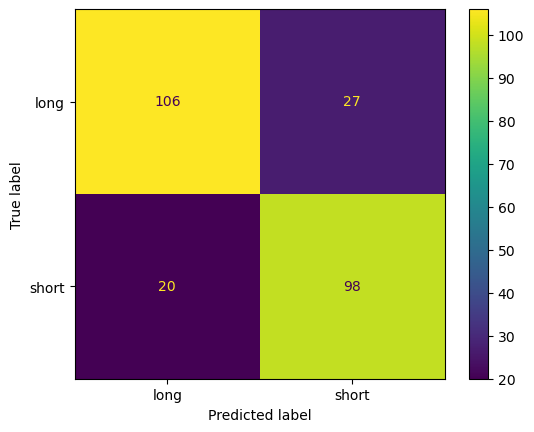

In [364]:
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)
f1_score(y_test, y_pred)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels= dir_encoder.classes_)


In [394]:
y_pred = rnd_clf.predict([[0,1,3,2,6]])
y_pred

array([0])

In [368]:
for name, score in zip(X.columns, rnd_clf.feature_importances_):
    print(name, score)

volume 0.13674633207998088
high_to_close 0.31804001409310706
low_to_close 0.3310056357587369
high_to_low 0.16705823775273548
days 0.04714978031543962


From the above two scores.... it's pretty plain to see that so far it not able to predict the correct day of the week give the volume and a few other <br>
features we've created. Why are we classifying on what should probably be a regression problem? Well if we can classify which day of the week it is <br>
when given price data, than technically we can reverse engineer and get the likely close (% up or down) given a day of the week. But so far no luck <br>
I'll go for a shower and ponder what we could change before bringing in outside factors.